In [1]:
import pandas as pd
import json
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

import matplotlib.pyplot as plt
import seaborn as sns


import glob

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [2]:
# -------------------------------
# Step 1: Load and merge datasets
# -------------------------------

files = [
    "/kaggle/input/human-and-language-model-generated-poems/human_ai_poems_v1.jsonl",
    "/kaggle/input/human-and-language-model-generated-poems/human_ai_poems_v1_gpt-turbo.jsonl",
    "/kaggle/input/human-and-language-model-generated-poems/human_ai_poems_v2_gemini.jsonl"
]

dfs = []
for f in files:
    df = pd.read_json(f, lines=True)
    dfs.append(df)

# Merge and shuffle
data = pd.concat(dfs, ignore_index=True)
data = data.sample(frac=1, random_state=42).reset_index(drop=True)

print("Dataset size:", len(data))
print("Columns:", data.columns.tolist())
print(data.head())

Dataset size: 1151
Columns: ['text', 'label']
                                                text    label
0  In the dust of a sunburnt town, where shadows ...  machine
1  In days of old, when empires rose and fell,\nK...  machine
2  Childhood Stories They learned to turn off the...    human
3  The Tale of Sunlight Listen, nephew.When I ope...    human
4  In a forgotten town, the willow weeps at twili...  machine


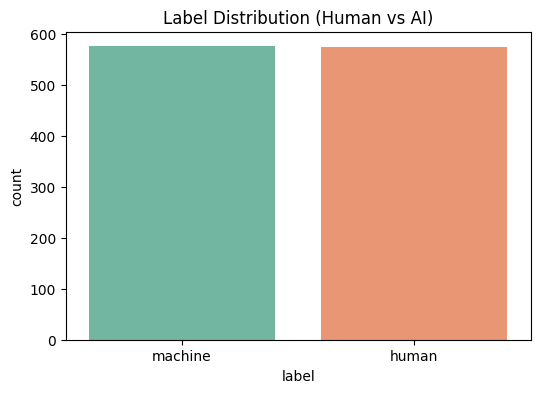

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


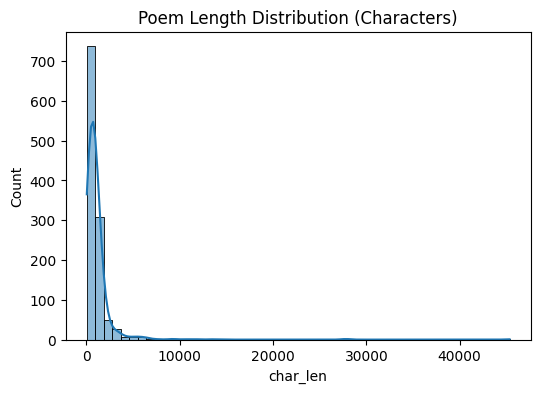

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


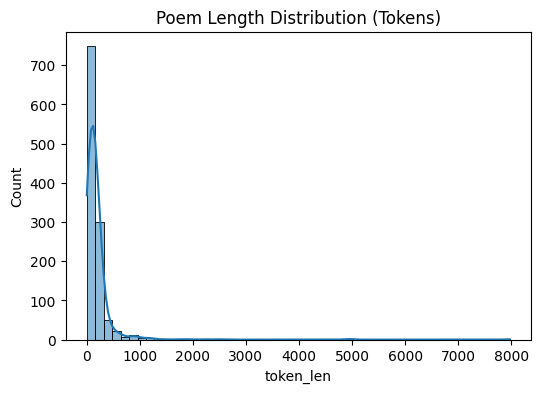


Average lengths by label:
            char_len   token_len
label                           
human    1470.935652  256.502609
machine   619.399306  107.513889

--- Sample Human Poem ---
Tulips The tulips are too excitable, it is winter here.Look how white everything is, how quiet, how snowed-in. I am learning peacefulness, lying by myself quietlyAs the light lies on these white walls, this bed, these hands. I am nobody; I have nothing to do with explosions. I have given my name and my day-clothes up to the nurses And my history to the anesthetist and my body to surgeons.They have propped my head between the pillow and the sheet-cuff Like an eye between two white lids that will not shut.Stupid pupil, it has to take everything in.The nurses pass and pass, they are no trouble,They pass the way gulls pass inland in their white caps,Doing things with their hands, one just the same as another, So it is impossible to tell how many there are.My body is a pebble to them, they tend it as waterTe

In [3]:
# -------------------------------
# Step 2: EDA (Exploratory Analysis)
# -------------------------------

# Label distribution
plt.figure(figsize=(6,4))
sns.countplot(x="label", data=data, palette="Set2")
plt.title("Label Distribution (Human vs AI)")
plt.show()

# Poem length in characters
data["char_len"] = data["text"].apply(len)
plt.figure(figsize=(6,4))
sns.histplot(data["char_len"], bins=50, kde=True)
plt.title("Poem Length Distribution (Characters)")
plt.show()

# Poem length in tokens (rough split by spaces)
data["token_len"] = data["text"].apply(lambda x: len(x.split()))
plt.figure(figsize=(6,4))
sns.histplot(data["token_len"], bins=50, kde=True)
plt.title("Poem Length Distribution (Tokens)")
plt.show()

# Average lengths by label
print("\nAverage lengths by label:")
print(data.groupby("label")[["char_len", "token_len"]].mean())

# Sample poems
print("\n--- Sample Human Poem ---")
print(data[data["label"]=="human"].sample(1, random_state=1).iloc[0]["text"])
print("\n--- Sample AI Poem ---")
print(data[data["label"]=="machine"].sample(1, random_state=1).iloc[0]["text"])


In [4]:
# -------------------------------
# Step 3: Preprocessing
# -------------------------------

def preprocess_poem(text):
    # 1. Normalize whitespace (remove extra spaces)
    text = re.sub(r'\s+', ' ', text)

    # 2. Normalize line breaks (convert multiple newlines to single \n)
    text = re.sub(r'(\n\s*)+', '\n', text)

    # 3. Remove strange tokens (like � or weird unicode)
    text = re.sub(r'[^\x00-\x7F]+', '', text)  # keep only ASCII

    # 4. Strip leading/trailing spaces
    text = text.strip()

    return text

data["clean_text"] = data["text"].apply(preprocess_poem)

# Verify preprocessing
print("\nOriginal Poem:\n", data.iloc[0]["text"])
print("\nCleaned Poem:\n", data.iloc[0]["clean_text"])

# Save processed dataset
data.to_csv("/kaggle/working/poems_cleaned.csv", index=False)
print("\n✅ Preprocessed dataset saved as poems_cleaned.csv")


Original Poem:
 In the dust of a sunburnt town, where shadows stretch long and thin, a lonesome rider rides the trail, a ghost of the West, worn and grim. His hat pulled low, the creek bed dry, whispers of the past like a fading hymn, lost lovers in the dusky glow, their laughter carried by the wind. The saloon doors creak, a familiar sound, the piano plays a tune of sorrow, he remembers her eyes, bright as stars, and the promise made, like a borrowed tomorrow. Outside the saloon, the cattle low, the prairie wind sings a ballad of old, a tale of heartache, of dreams undone, where the brave are buried, and the stories told. He tips his hat to the painted sky, where the sunset bleeds crimson and gold, each note a memory, each chord a tear, the weight of the world on shoulders bold. A showdown waits at the edge of town, two souls collide in a dance of fate, but beneath the bravado, the gunfire's roar, the heart beats softly, a wish too late. In the end, he rides into twilight's glow, his

In [5]:
import hashlib
def stable_id(s): 
    return hashlib.md5(s.encode('utf-8')).hexdigest()
data['poem_id'] = data['clean_text'].apply(stable_id)
data = data.drop_duplicates(subset=['poem_id']).reset_index(drop=True)


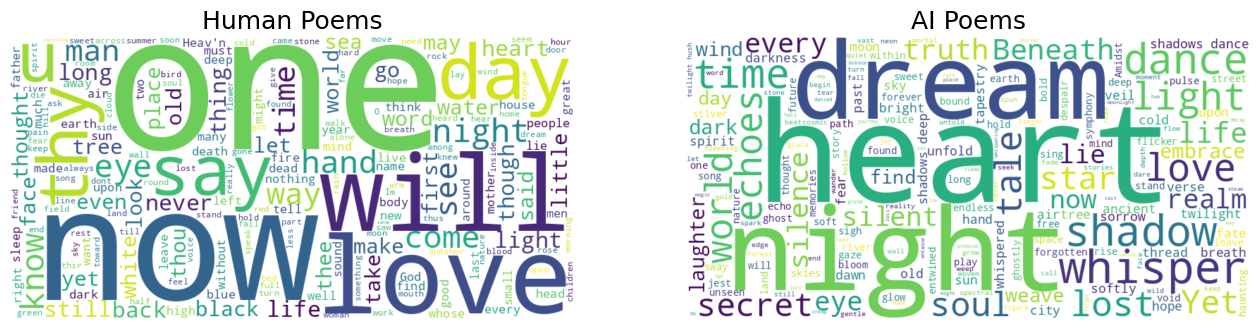

In [6]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Separate human and AI poems
human_text = " ".join(data[data['label'] == "human"]["clean_text"])
ai_text = " ".join(data[data['label'] == "machine"]["clean_text"])


# Generate word clouds
wc_human = WordCloud(width=800, height=400, background_color="white").generate(human_text)
wc_ai = WordCloud(width=800, height=400, background_color="white").generate(ai_text)

# Plot side by side
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.imshow(wc_human, interpolation="bilinear")
plt.axis("off")
plt.title("Human Poems", fontsize=18)

plt.subplot(1, 2, 2)
plt.imshow(wc_ai, interpolation="bilinear")
plt.axis("off")
plt.title("AI Poems", fontsize=18)

plt.show()


In [7]:
from sklearn.model_selection import train_test_split

# Train-test split with stratification (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    data['clean_text'],
    data['label'],
    test_size=0.4,
    stratify=data['label'],
    random_state=42
)

# Vectorize
vectorizer = TfidfVectorizer(ngram_range=(1,2))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf  = vectorizer.transform(X_test)


In [8]:
# X_train, X_test, y_train, y_test = train_test_split(
#     data['clean_text'], data['label'], test_size=0.2, random_state=42, stratify=data['label']
# )

In [9]:
# vectorizer = TfidfVectorizer(ngram_range=(1,2))
# X_train_tfidf = vectorizer.fit_transform(X_train)

# # Transform val and test with the same vectorizer
# X_val_tfidf   = vectorizer.transform(X_val)
# X_test_tfidf  = vectorizer.transform(X_test)

In [10]:
data.shape

(951, 6)

In [11]:
# --------------------------
# Step 5: Logistic Regression Model
# --------------------------
clf = LogisticRegression(max_iter=200, class_weight="balanced")
clf.fit(X_train_tfidf, y_train)

# --------------------------
# Step 6: Evaluation
# --------------------------
y_pred = clf.predict(X_test_tfidf)

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nAccuracy:", accuracy_score(y_test, y_pred))


Confusion Matrix:
[[186   4]
 [ 10 181]]

Classification Report:
              precision    recall  f1-score   support

       human       0.95      0.98      0.96       190
     machine       0.98      0.95      0.96       191

    accuracy                           0.96       381
   macro avg       0.96      0.96      0.96       381
weighted avg       0.96      0.96      0.96       381


Accuracy: 0.963254593175853


In [12]:
# !pip install -q -U "transformers>=4.41,<5" "accelerate>=0.29"
# import transformers, torch
# print("Transformers:", transformers.__version__, "| Torch CUDA:", torch.cuda.is_available())


In [13]:
# ==== Fine-tune pretrained BERT on your existing splits ====

import numpy as np, torch
from torch.utils.data import Dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import DataCollatorWithPadding, Trainer, TrainingArguments, set_seed

SEED = 42
set_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -------------------------------
# Encode labels
# -------------------------------
label2id = {"human": 0, "machine": 1}
id2label = {v: k for k, v in label2id.items()}
to_id = lambda s: label2id[str(s).strip().lower()]

y_train_id = np.array([to_id(s) for s in y_train])
y_test_id  = np.array([to_id(s) for s in y_test])

# -------------------------------
# Dataset class
# -------------------------------
class TextClsDS(Dataset):
    def __init__(self, texts, labels, tok, max_len=512):
        self.texts = list(texts)
        self.labels = list(labels)
        self.tok = tok
        self.max_len = max_len
    def __len__(self): return len(self.texts)
    def __getitem__(self, i):
        enc = self.tok(self.texts[i], truncation=True, max_length=self.max_len, padding=False)
        enc["labels"] = int(self.labels[i])
        return {k: torch.tensor(v) for k, v in enc.items()}

# -------------------------------
# Tokenizer + datasets
# -------------------------------
MODEL_NAME = "bert-base-uncased"
tok = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)

train_ds = TextClsDS(X_train, y_train_id, tok, max_len=512)
test_ds  = TextClsDS(X_test,  y_test_id,  tok, max_len=512)

# -------------------------------
# Model
# -------------------------------
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2,
    problem_type="single_label_classification",
    label2id=label2id,
    id2label=id2label
).to(device)

# -------------------------------
# Metrics
# -------------------------------
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    acc = accuracy_score(labels, preds)
    p, r, f1, _ = precision_recall_fscore_support(labels, preds, average="binary", zero_division=0)
    return {"accuracy": acc, "precision": p, "recall": r, "f1": f1}

# -------------------------------
# Training
# -------------------------------
from transformers import TrainingArguments

args = TrainingArguments(
    output_dir="./bert-poetry-clf",
    overwrite_output_dir=True,
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_steps=50,
    save_total_limit=2,
    fp16=torch.cuda.is_available(),
    seed=SEED,
    report_to="none"
)


trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_ds,
    eval_dataset=test_ds,  # using test set directly since no val
    tokenizer=tok,
    data_collator=DataCollatorWithPadding(tok),
    compute_metrics=compute_metrics,
)

trainer.train()

# Evaluate once after training
print("Test evaluation:", trainer.evaluate(test_ds))


# -------------------------------
# Evaluation
# -------------------------------
print("Test evaluation:", trainer.evaluate(test_ds))

pred = trainer.predict(test_ds)
y_true = pred.label_ids
y_pred = np.argmax(pred.predictions, axis=1)

print("\nClassification Report:\n", classification_report(
    y_true, y_pred, target_names=["human","machine"], digits=4
))

# -------------------------------
# Save model
# -------------------------------
trainer.save_model("./bert-poetry-clf-best")
tok.save_pretrained("./bert-poetry-clf-best")


2025-08-26 06:27:11.482821: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756189631.821223      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756189631.914788      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_36/2320748368.py:89: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
50,0.284300
100,0.050700


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Test evaluation: {'eval_loss': 0.08370186388492584, 'eval_accuracy': 0.973753280839895, 'eval_precision': 0.9547738693467337, 'eval_recall': 0.9947643979057592, 'eval_f1': 0.9743589743589743, 'eval_runtime': 6.3492, 'eval_samples_per_second': 60.007, 'eval_steps_per_second': 1.89, 'epoch': 3.0}


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Test evaluation: {'eval_loss': 0.08370186388492584, 'eval_accuracy': 0.973753280839895, 'eval_precision': 0.9547738693467337, 'eval_recall': 0.9947643979057592, 'eval_f1': 0.9743589743589743, 'eval_runtime': 6.2586, 'eval_samples_per_second': 60.876, 'eval_steps_per_second': 1.917, 'epoch': 3.0}


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



Classification Report:
               precision    recall  f1-score   support

       human     0.9945    0.9526    0.9731       190
     machine     0.9548    0.9948    0.9744       191

    accuracy                         0.9738       381
   macro avg     0.9746    0.9737    0.9737       381
weighted avg     0.9746    0.9738    0.9737       381



('./bert-poetry-clf-best/tokenizer_config.json',
 './bert-poetry-clf-best/special_tokens_map.json',
 './bert-poetry-clf-best/vocab.txt',
 './bert-poetry-clf-best/added_tokens.json',
 './bert-poetry-clf-best/tokenizer.json')

Accuracy: 0.973753280839895

Classification Report:
               precision    recall  f1-score   support

       human       0.95      0.99      0.97       190
     machine       0.99      0.95      0.97       191

    accuracy                           0.97       381
   macro avg       0.97      0.97      0.97       381
weighted avg       0.97      0.97      0.97       381



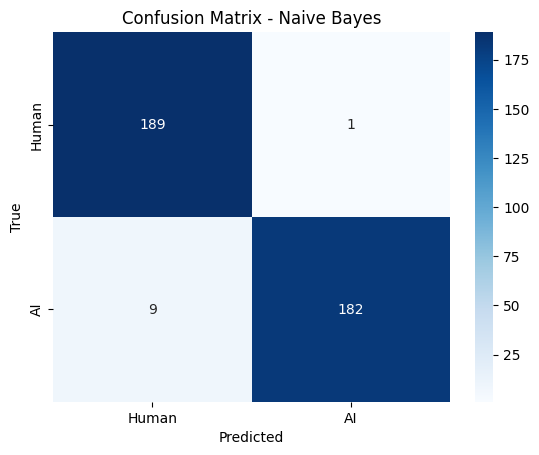

In [14]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Train Naive Bayes model
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)

# Predictions
y_pred = nb_model.predict(X_test_tfidf)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=["human", "machine"])
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Human", "AI"], yticklabels=["Human", "AI"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Naive Bayes")
plt.show()


In [15]:
# ==== RNN (LSTM) Classifier ====

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report
from transformers import AutoTokenizer

# -------------------------------
# 1. Encode labels
# -------------------------------
label2id = {"human": 0, "machine": 1}
id2label = {0: "human", 1: "machine"}
to_id = lambda s: label2id[str(s).strip().lower()]

y_train_id = [to_id(s) for s in y_train]
y_test_id  = [to_id(s) for s in y_test]

# -------------------------------
# 2. Tokenizer (use BERT tokenizer or your own)
# -------------------------------
tok = AutoTokenizer.from_pretrained("bert-base-uncased", use_fast=True)

MAX_LEN = 128  # keep poems reasonably short for RNN

def encode_batch(texts, labels):
    enc = tok(
        list(texts),
        truncation=True,
        padding="max_length",
        max_length=MAX_LEN,
        return_tensors="pt"
    )
    return enc["input_ids"], enc["attention_mask"], torch.tensor(labels)

# -------------------------------
# 3. Dataset class
# -------------------------------
class PoetryDS(Dataset):
    def __init__(self, texts, labels):
        self.input_ids, self.attn_masks, self.labels = encode_batch(texts, labels)
    def __len__(self): return len(self.labels)
    def __getitem__(self, i):
        return {
            "input_ids": self.input_ids[i],
            "attention_mask": self.attn_masks[i],
            "labels": self.labels[i]
        }

train_ds = PoetryDS(X_train, y_train_id)
test_ds  = PoetryDS(X_test,  y_test_id)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=32)

# -------------------------------
# 4. RNN Model
# -------------------------------
class RNNClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, hidden_dim=128, num_classes=2):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)
    def forward(self, input_ids, attention_mask=None, labels=None):
        x = self.embedding(input_ids)                # [batch, seq, embed_dim]
        _, (h_n, _) = self.lstm(x)                   # h_n = [1, batch, hidden_dim]
        logits = self.fc(h_n.squeeze(0))             # [batch, num_classes]
        return logits

# -------------------------------
# 5. Training setup
# -------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

VOCAB_SIZE = tok.vocab_size
model = RNNClassifier(vocab_size=VOCAB_SIZE).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=2e-3)

# -------------------------------
# 6. Training loop
# -------------------------------
EPOCHS = 5

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for batch in train_loader:
        input_ids = batch["input_ids"].to(device)
        labels = batch["labels"].to(device)

        optimizer.zero_grad()
        logits = model(input_ids)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {total_loss/len(train_loader):.4f}")

# -------------------------------
# 7. Evaluation
# -------------------------------
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        labels = batch["labels"].to(device)
        logits = model(input_ids)
        preds = torch.argmax(logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print("\nClassification Report:\n", classification_report(
    all_labels, all_preds, target_names=["human","machine"], digits=4
))


Epoch 1/5, Loss: 0.6609
Epoch 2/5, Loss: 0.3358
Epoch 3/5, Loss: 0.2340
Epoch 4/5, Loss: 0.2382
Epoch 5/5, Loss: 0.2905

Classification Report:
               precision    recall  f1-score   support

       human     0.9206    0.9158    0.9182       190
     machine     0.9167    0.9215    0.9191       191

    accuracy                         0.9186       381
   macro avg     0.9187    0.9186    0.9186       381
weighted avg     0.9186    0.9186    0.9186       381



In [16]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# -------------------------------
# 1. Tokenization & Padding
# -------------------------------
MAX_VOCAB = 10000
MAX_LEN = 200  # max words per poem

tokenizer = Tokenizer(num_words=MAX_VOCAB, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)  # X_train is your cleaned text from previous cell

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq  = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding="post", truncating="post")
X_test_pad  = pad_sequences(X_test_seq,  maxlen=MAX_LEN, padding="post", truncating="post")

# -------------------------------
# 2. Convert string labels -> numeric
# -------------------------------
label2id = {"human": 0, "machine": 1}
y_train_num = np.array([label2id[label] for label in y_train])
y_test_num  = np.array([label2id[label] for label in y_test])

# -------------------------------
# 3. CNN Model
# -------------------------------
vocab_size = len(tokenizer.word_index) + 1  # total words + padding
max_len = X_train_pad.shape[1]              # sequence length

cnn_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=128),  # input_length optional
    Conv1D(filters=128, kernel_size=5, activation="relu"),
    GlobalMaxPooling1D(),
    Dense(64, activation="relu"),
    Dropout(0.5),
    Dense(1, activation="sigmoid")   # binary classification
])

cnn_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# -------------------------------
# 4. Training
# -------------------------------
cnn_history = cnn_model.fit(
    X_train_pad, y_train_num,
    validation_data=(X_test_pad, y_test_num),
    epochs=10,
    batch_size=32,
    verbose=1
)

# -------------------------------
# 5. Evaluation
# -------------------------------
loss, acc = cnn_model.evaluate(X_test_pad, y_test_num, verbose=0)
print(f"Test Accuracy (CNN): {acc:.4f}")


Epoch 1/10


I0000 00:00:1756189769.496517      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9246 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1756189769.497115      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 10502 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
I0000 00:00:1756189771.790938     421 service.cc:148] XLA service 0x7faa10008560 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1756189771.792095     421 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1756189771.792117     421 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1756189772.279321     421 cuda_dnn.cc:529] Loaded cuDNN version 90300


15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5158 - loss: 0.6926 

I0000 00:00:1756189775.900884     421 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 168ms/step - accuracy: 0.5273 - loss: 0.6906 - val_accuracy: 0.8268 - val_loss: 0.6541
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8782 - loss: 0.6117 - val_accuracy: 0.8845 - val_loss: 0.5453
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8994 - loss: 0.4472 - val_accuracy: 0.9291 - val_loss: 0.3000
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9694 - loss: 0.2079 - val_accuracy: 0.9528 - val_loss: 0.1645
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9917 - loss: 0.0689 - val_accuracy: 0.9528 - val_loss: 0.1224
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9960 - loss: 0.0255 - val_accuracy: 0.9633 - val_loss: 0.1059
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.0135 - val_accuracy: 0.9606 - val_loss: 0.1033
Epoch 8/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.0048 - val_accuracy: 0.9606 - val_loss: 0.0988
E

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report
from transformers import AutoTokenizer

# -------------------------------
# 1. Encode labels
# -------------------------------
label2id = {"human": 0, "machine": 1}
to_id = lambda s: label2id[str(s).strip().lower()]

y_train_id = [to_id(s) for s in y_train]
y_test_id  = [to_id(s) for s in y_test]

# -------------------------------
# 2. Tokenizer
# -------------------------------
tok = AutoTokenizer.from_pretrained("bert-base-uncased", use_fast=True)
MAX_LEN = 128

def encode_batch(texts, labels):
    enc = tok(
        list(texts),
        truncation=True,
        padding="max_length",
        max_length=MAX_LEN,
        return_tensors="pt"
    )
    return enc["input_ids"], enc["attention_mask"], torch.tensor(labels)

# -------------------------------
# 3. Dataset class
# -------------------------------
class PoetryDS(Dataset):
    def __init__(self, texts, labels):
        self.input_ids, self.attn_masks, self.labels = encode_batch(texts, labels)
    def __len__(self): return len(self.labels)
    def __getitem__(self, i):
        return {
            "input_ids": self.input_ids[i],
            "attention_mask": self.attn_masks[i],
            "labels": self.labels[i]
        }

train_ds = PoetryDS(X_train, y_train_id)
test_ds  = PoetryDS(X_test,  y_test_id)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=32)

# -------------------------------
# 4. Vanilla RNN Model
# -------------------------------
class VanillaRNNClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, hidden_dim=128, num_classes=2):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.rnn = nn.RNN(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)
    def forward(self, input_ids, attention_mask=None, labels=None):
        x = self.embedding(input_ids)            # [batch, seq, embed_dim]
        _, h_n = self.rnn(x)                     # h_n = [1, batch, hidden_dim]
        logits = self.fc(h_n.squeeze(0))         # [batch, num_classes]
        return logits

# -------------------------------
# 5. Training setup
# -------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
VOCAB_SIZE = tok.vocab_size

model = VanillaRNNClassifier(vocab_size=VOCAB_SIZE).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=2e-3)

# -------------------------------
# 6. Training loop
# -------------------------------
EPOCHS = 5

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for batch in train_loader:
        input_ids = batch["input_ids"].to(device)
        labels = batch["labels"].to(device)

        optimizer.zero_grad()
        logits = model(input_ids)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {total_loss/len(train_loader):.4f}")

# -------------------------------
# 7. Evaluation
# -------------------------------
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        labels = batch["labels"].to(device)
        logits = model(input_ids)
        preds = torch.argmax(logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print("\nClassification Report:\n", classification_report(
    all_labels, all_preds, target_names=["human","machine"], digits=4
))


Epoch 1/5, Loss: 0.6861
Epoch 2/5, Loss: 0.5480
Epoch 3/5, Loss: 0.3704
Epoch 4/5, Loss: 0.3637
Epoch 5/5, Loss: 0.5745

Classification Report:
               precision    recall  f1-score   support

       human     0.5574    0.7158    0.6267       190
     machine     0.6058    0.4346    0.5061       191

    accuracy                         0.5748       381
   macro avg     0.5816    0.5752    0.5664       381
weighted avg     0.5817    0.5748    0.5663       381

